In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler #normalization

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [14]:
df= pd.read_csv('/content/drive/MyDrive/OneDrive_1_3-7-2022/df4.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

In [16]:
df.head()

,ID,RECALCGPA,AppDate,AdmitDate,SCHOLARSHIPTEST,TMST_15,PELL_EFC_CENSUS,FirstInqDate,EntryTerm_202160,MaxEntryStatus_F,...,NumberOfVisits_4,NumberOfVisits_5,GENDER_F,FirstGen_N,LEGACY_A,LEGACY_G,LEGACY_None,LEGACY_P,LEGACY_S,LEGACY_U
0,120957007,2.70,36,38,14.0,0,0.0,65,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,102554310,2.95,99,77,18.0,0,0.0,289,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,170965039,3.63,105,76,28.0,0,10564.0,694,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,131260604,4.00,119,87,24.0,0,20587.0,357,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,119542072,4.00,55,19,20.0,1,0.0,741,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


#Test train split

In [17]:
import random
random.seed(10)

x=df.drop('TMST_15', axis=1)
y= df['TMST_15'] #1 - Not enrolled , 0 - Enrolled

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=12, stratify=y)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11060, 218)
(11060,)
(4740, 218)
(4740,)


In [19]:
#Stratified test and train set
print("Class % in Train set: ", y_train.value_counts(normalize=True))

print("Class % in Test set: ", y_test.value_counts(normalize=True))

Class % in Train set:  1    0.744394
0    0.255606
Name: TMST_15, dtype: float64
Class % in Test set:  1    0.744304
0    0.255696
Name: TMST_15, dtype: float64


#Random Forest

##Random forest (SMOTE)

In [20]:
#Class Imbalance handling using SMOTE
from imblearn.over_sampling import SMOTE 
smote = SMOTE(sampling_strategy='auto' , random_state=12 , k_neighbors=5 )
x_train_ovrs, y_train_ovrs = smote.fit_resample(x_train, y_train)


###GridSearchCV used to find the optimal hyperparameters

In [21]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(1,15, 2),
    'criterion' :['gini', 'entropy']
}

In [22]:
model_rf1 = RandomForestClassifier( bootstrap= True, 
                                random_state= 0, class_weight='balanced')

rf_grid = GridSearchCV(estimator=model_rf1, param_grid=param_grid, cv= 5, verbose=2, n_jobs=-1)
fit1 = rf_grid.fit(x_train_ovrs, y_train_ovrs)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [23]:
fit1.best_params_

{'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 'auto',
 'n_estimators': 500}

In [24]:
fit1.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, n_estimators=500, random_state=0)

###Fitting the model using the optimal hyperparameters

In [25]:
model_rf_best = RandomForestClassifier( bootstrap= True, 
                                random_state= 0, 
                                class_weight='balanced', 
                                criterion= 'entropy',
                                max_depth= 13,
                                 max_features= 'auto',
                                 n_estimators= 500)

In [26]:
rf_fit = model_rf_best.fit(x_train_ovrs,y_train_ovrs)
rf_pred = rf_fit.predict(x_test)
print('ROC/AUC score with SMOTE:',roc_auc_score(y_test, rf_pred))

ROC/AUC score with SMOTE: 0.9292407557082238


In [27]:
rf_fit2 = model_rf_best.fit(x_train, y_train)
rf_pred2 = rf_fit.predict(x_test)
print('ROC/AUC score without SMOTE:',roc_auc_score(y_test, rf_pred2))

ROC/AUC score without SMOTE: 0.933098156754451


In [39]:
rf_prob = rf_fit.predict_proba(x_test)
pd.DataFrame(rf_prob)

,0,1
0,0.091342,0.908658
1,0.842572,0.157428
2,0.204771,0.795229
3,0.816769,0.183231
4,0.274567,0.725433
...,...,...
4735,0.075277,0.924723
4736,0.224131,0.775869
4737,0.283510,0.716490
4738,0.080718,0.919282


In [32]:
print('ROC/AUC score:',round(roc_auc_score(y_test, rf_pred),4))
print('Accuracy:', round(accuracy_score(y_test, rf_pred),4))
print ('F1 score:', round(f1_score(y_test, rf_pred),4))
print ('Recall:', round(recall_score(y_test, rf_pred),4))
print ('Precision:', round(precision_score(y_test, rf_pred),4))
print ('\n clasification report:\n', classification_report(y_test, rf_pred))
print ('\n confusion matrix:\n',confusion_matrix(y_test, rf_pred))


ROC/AUC score: 0.9292
Accuracy: 0.9568
F1 score: 0.9714
Recall: 0.9855
Precision: 0.9576

 clasification report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      1212
           1       0.96      0.99      0.97      3528

    accuracy                           0.96      4740
   macro avg       0.96      0.93      0.94      4740
weighted avg       0.96      0.96      0.96      4740


 confusion matrix:
 [[1058  154]
 [  51 3477]]


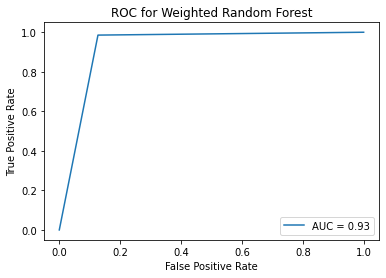

In [33]:
from sklearn import metrics
import matplotlib.pyplot as plt

ax= plt.subplot()
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
ax.set_title('ROC for Weighted Random Forest')
display.plot(ax=ax)

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix for Weighted Random Forest')

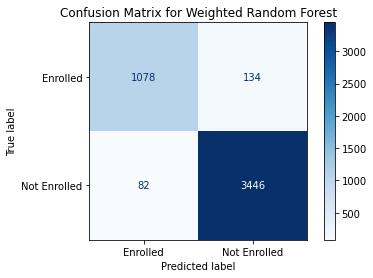

In [34]:
ax= plt.subplot()
cf_rf = plot_confusion_matrix(model_rf_best, x_test, y_test, cmap='Blues', display_labels=['Enrolled', 'Not Enrolled'], ax=ax)
ax.set_title('Confusion Matrix for Weighted Random Forest')

###Feature Importance using Random forest

In [36]:
feature_list = list(x_train.columns)
importances = list(rf_fit.feature_importances_)

feature_importances =pd.DataFrame(zip(feature_list, importances), columns=['Features', 'Importance score'])
feature_importances['Importance_%'] = (feature_importances['Importance score']*100)
feature_importances = feature_importances.sort_values(by='Importance_%', axis=0, ascending= False )
feature_importances['Importance_cum'] = np.cumsum(feature_importances['Importance_%'])

feature_importances[feature_importances['Importance_%']>0.5][:15]

,Features,Importance score,Importance_%,Importance_cum
170,LOAN_ACPT_0,0.191950,19.195026,19.195026
166,SCH_ACPT_N,0.177148,17.714785,36.909810
168,SCH_ACPT_Y,0.169119,16.911929,53.821739
171,LOAN_DECLINE_0,0.079112,7.911221,61.732960
5,PELL_EFC_CENSUS,0.028651,2.865060,64.598021
205,NumberOfVisits_0,0.022351,2.235079,66.833100
140,PARMARITALSTATUS_Not Applicable,0.021132,2.113176,68.946276
1,RECALCGPA,0.018142,1.814213,70.760489
4,SCHOLARSHIPTEST,0.016701,1.670127,72.430616
3,AdmitDate,0.016519,1.651869,74.082485


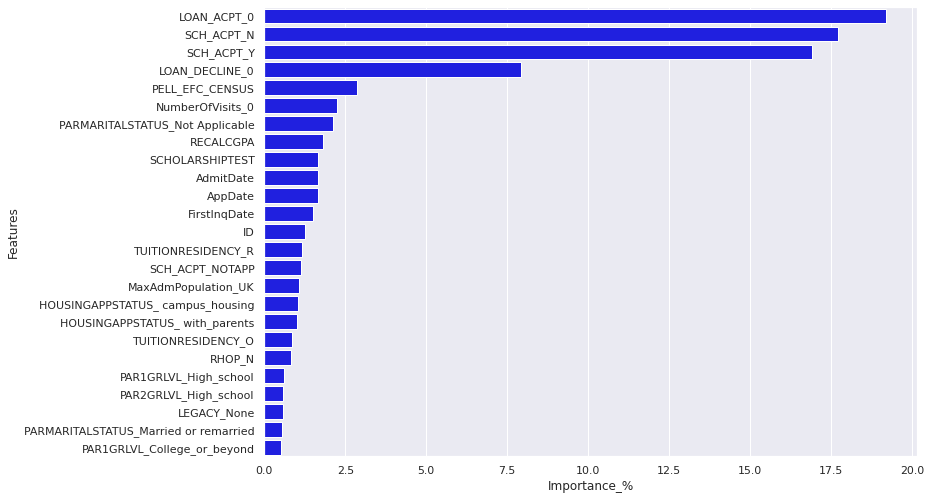

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(y="Features", 
            x="Importance_%", 
            data=feature_importances[feature_importances['Importance_%']>0.5],
            orient='h',
            color= "blue",
            
            order=feature_importances[feature_importances['Importance_%']>0.5].sort_values('Importance_%',ascending = False).Features)


#Support Vector Machines(SVM)

In [47]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform( x_train_ovrs )
x_test_s = scaler.fit_transform( x_test )

In [ ]:
model_svm = svm.SVC(class_weight='balanced')
param = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
svm_grid = GridSearchCV(model_svm, param , refit=True, verbose=2)
svm_grid.fit(x_train_s,y_train_ovrs)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  38.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  58.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  57.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  55.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  56.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  13.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  10.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  10.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  10.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  10.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  16.1s
[CV] END .....................C=0.1, gamma=1, k

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [ ]:
svm_grid.best_estimator_

SVC(C=10, class_weight='balanced', gamma=0.01, kernel='poly')

In [48]:
model_svm_best = svm.SVC(C=10, class_weight='balanced', gamma=0.01, kernel='poly')
svmmodel_fit = model_svm_best.fit(x_train_s,y_train_ovrs)
svm_pred = svmmodel_fit.predict(x_test_s)
print('Accuracy using kernal function is:' , round(accuracy_score(y_test, svm_pred),4)*100)

Accuracy using kernal function is: 90.14999999999999


In [49]:
print('ROC/AUC score:',round(roc_auc_score(y_test, svm_pred),4))
print('Accuracy:', round(accuracy_score(y_test, svm_pred),4))
print ('F1 score:', round(f1_score(y_test, svm_pred),4))
print ('Recall:', round(recall_score(y_test, svm_pred),4))
print ('Precision:', round(precision_score(y_test, svm_pred),4))
print ('\n clasification report:\n', classification_report(y_test, svm_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, svm_pred))

ROC/AUC score: 0.9032
Accuracy: 0.9015
F1 score: 0.9315
Recall: 0.8997
Precision: 0.9656

 clasification report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.82      1212
           1       0.97      0.90      0.93      3528

    accuracy                           0.90      4740
   macro avg       0.86      0.90      0.88      4740
weighted avg       0.91      0.90      0.90      4740


 confussion matrix:
 [[1099  113]
 [ 354 3174]]


#Gradient Boosting Classifier

In [ ]:
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall':make_scorer(recall_score)}

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01,0.03, 0.05, 0.07, 0.09, 0.1],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "absolute_error"],
    "subsample":[0.5, 0.6,0.7, 0.8, 0.9, 1.0],
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1, verbose=2 )

clf.fit(x_train_ovrs, y_train_ovrs)

df=pd.DataFrame.from_dict(clf.cv_results_)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

Fitting 2 folds for each of 432 candidates, totalling 864 fits


,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.862140,0.984210,0.787949,0.995032,0.991013,0.973275
1,0.836390,0.961496,0.756862,0.987426,0.991256,0.934888
2,0.819507,0.963926,0.743656,0.993538,0.975225,0.933916
3,0.855338,0.958217,0.781563,0.978195,0.986398,0.937318
4,0.819871,0.963075,0.741651,0.987967,0.981783,0.937561
...,...,...,...,...,...,...
427,0.873679,0.986396,0.801135,0.997762,0.994171,0.974976
428,0.883275,0.987246,0.814217,0.999005,0.993199,0.975462
429,0.890441,0.987246,0.823897,0.998757,0.993199,0.975705
430,0.874529,0.985667,0.801998,0.998504,0.994656,0.972789


In [ ]:
#find the best parameter based on the accuracy_score
#taking the average of the accuracy_score
df['accuracy_score']=(df['split0_test_accuracy']+df['split1_test_accuracy'])/2

df.loc[df['accuracy_score'].idxmax()]['params']

{'criterion': 'mae',
 'learning_rate': 0.01,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'sqrt',
 'subsample': 0.5}

In [42]:
model_gbc = GradientBoostingClassifier(criterion='absolute_error', 
                                       learning_rate=0.01, 
                                       loss='deviance',
                                       max_depth= 8,
                                       max_features='sqrt',
                                       n_estimators=10, 
                                       subsample=0.5, 
                                       random_state=0).fit(x_train_ovrs, y_train_ovrs)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1290: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  FutureWarning,


In [41]:
gbc_pred=model_gbc.predict(x_test)

In [47]:
print('ROC/AUC score:',round(roc_auc_score(y_test, gbc_pred),4))
print('Accuracy:', round(accuracy_score(y_test, gbc_pred),4))
print ('F1 score:', round(f1_score(y_test, gbc_pred),4))
print ('Recall:', round(recall_score(y_test, gbc_pred),4))
print ('Precision:', round(precision_score(y_test, gbc_pred),4))
print ('\n clasification report:\n', classification_report(y_test, gbc_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, gbc_pred))

ROC/AUC score: 0.9218
Accuracy: 0.9468
F1 score: 0.9646
Recall: 0.9731
Precision: 0.9563

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      1212
           1       0.96      0.97      0.96      3528

    accuracy                           0.95      4740
   macro avg       0.94      0.92      0.93      4740
weighted avg       0.95      0.95      0.95      4740


 confussion matrix:
 [[1055  157]
 [  95 3433]]
